# 67 Rotating GemPy Input Data

This notebook illustrates how to rotate GemPy Input data. Input data may be rotated because subsurface structures do not trend West-East or North-South but rather oblique. As GemPy only takes extents that are oriented N-S and W-E, there would be a large area that would be discarded after the modeling process and does not need to be modeled in the first place. Rotating the data will therefore reduce the area that needs to be calculated and therefore computing times which may allow for a higher resolution or the integration of more input data. The rotation implemented in GemGIS is performed around the center point of the extent of the model. This does not only allow for rotating the data at its place (instead of rotating it around (0,0) which may cause a translation of the model to extreme coordinates, but also for rotating the resulting meshes back to their original orientation. 

<img src="../images/tutorial67_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gempy as gp
import gemgis as gg
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import pyvista as pv
pv.set_jupyter_backend('client')

No module named 'osgeo'


WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
file_path ='data/67_rotating_gempy_input_data/'
gg.download_gemgis_data.download_tutorial_data(filename="67_rotation_gempy_input_data.zip", dirpath=file_path)

## Loading Input Data

In [3]:
interfaces = pd.read_csv(file_path + 'interfaces.csv', delimiter=';')
interfaces.head()

,X,Y,Z,formation
0,200,250,-100,Layer1
1,200,500,-100,Layer1
2,200,750,-100,Layer1
3,200,250,-200,Layer2
4,200,500,-200,Layer2


In [4]:
orientations = pd.read_csv(file_path + 'orientations.csv', delimiter=';')
orientations.head()

,X,Y,Z,formation,dip,azimuth,polarity
0,200,500,-100,Layer1,0,0,1
1,800,500,-100,Layer1,0,0,1
2,500,500,-300,Layer1,0,0,1
3,250,500,-100,Fault1,60,90,1
4,750,500,-100,Fault2,60,270,1


## Creating Polygon Extent

The original extent of the model will be translated into a Shapely Polygon.

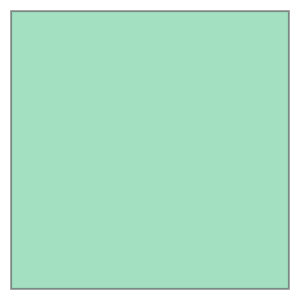

In [5]:
extent = Polygon([(0,0), (0,1000), (1000, 1000), (1000,0)])
extent

## Performing initial rotation for Tutorial

The input data will be rotated a first time to create a non-N-S-W-E oriented dataset. 

In [6]:
extent_rotated, interfaces_rotated, orientations_rotated, extent_gdf = gg.utils.rotate_gempy_input_data(extent=extent,
                                                                                                        interfaces=interfaces,
                                                                                                        orientations=orientations,
                                                                                                        zmin=-600, 
                                                                                                        zmax=0, 
                                                                                                        return_extent_gdf=True,
                                                                                                        manual_rotation_angle=33)
extent_rotated, interfaces_rotated.head(), orientations_rotated.head(), extent_gdf

([-191.65480148022556,
  1191.6548014802256,
  -191.65480148022556,
  1191.6548014802256,
  -600,
  0],
        X      Y       Z formation                 geometry
 0 112.24 453.72 -100.00    Layer1  POINT (112.239 453.724)
 1 248.40 663.39 -100.00    Layer1  POINT (248.399 663.392)
 2 384.56 873.06 -100.00    Layer1  POINT (384.559 873.059)
 3 112.24 453.72 -200.00    Layer2  POINT (112.239 453.724)
 4 248.40 663.39 -200.00    Layer2  POINT (248.399 663.392),
        X      Y       Z formation   dip  azimuth  polarity   
 0 248.40 663.39 -100.00    Layer1  0.00     0.00      1.00  \
 1 751.60 336.61 -100.00    Layer1  0.00     0.00      1.00   
 2 500.00 500.00 -300.00    Layer1  0.00     0.00      1.00   
 3 290.33 636.16 -100.00    Fault1 60.00    90.00      1.00   
 4 709.67 363.84 -100.00    Fault2 60.00   270.00      1.00   
 
                   geometry  
 0  POINT (248.399 663.392)  
 1  POINT (751.601 336.608)  
 2  POINT (500.000 500.000)  
 3  POINT (290.332 636.160)  
 4  P

## Plotting the non-N-S-W-E Model Data

Plotting the input data shows that the graben structure is striking NW-SE. This is not ideal for modeling in GemPy. In order to model the entire black extent that is desired, the red extent would have to be modeled which results in a much larger model than necessary. 

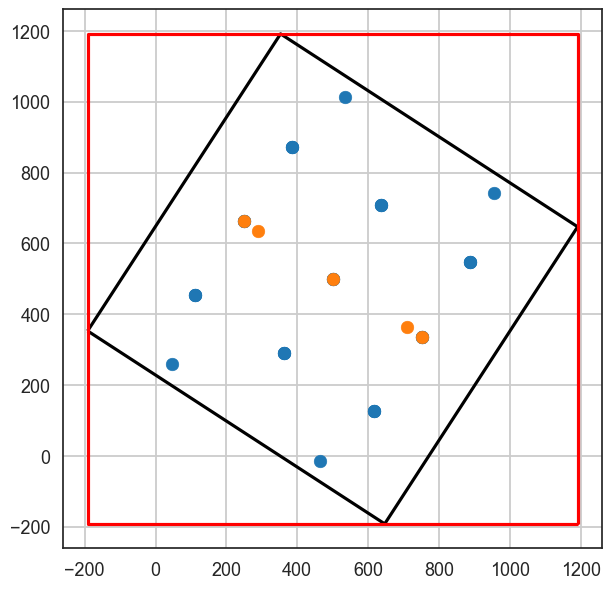

In [7]:
fig, ax = plt.subplots(1, figsize=(7,7))

extent_gdf.boundary.plot(ax=ax, color='black')
interfaces_rotated.plot(ax=ax)
orientations_rotated.plot(ax=ax)
gpd.GeoDataFrame(geometry=[box(*extent_gdf.total_bounds)]).boundary.plot(ax=ax, color='red')
plt.grid()

## Rotating the Model back to a N-S-W-E-oriented model

The non-N-S-W-E-oriented model can be rotated to a N-S-W-E-oriented model using the GemGIS function ```gg.utils.rotate_gempy_input_data(...)```. The rotation angle is either calculated automatically or can be set manually. 

In [8]:
extent_straight, interfaces_straight, orientations_straight, extent_gdf_straight = gg.utils.rotate_gempy_input_data(extent=extent_gdf,
                                                                                                                    interfaces=interfaces_rotated,
                                                                                                                    orientations=orientations_rotated,
                                                                                                                    zmin=-600, 
                                                                                                                    zmax=0, 
                                                                                                                    rotate_reverse_direction=True,                            
                                                                                                                    return_extent_gdf=True)
extent_straight, interfaces_straight.head(), orientations_straight.head(), extent_gdf_straight

([-1.1368683772161603e-13, 1000.0, -2.842170943040401e-14, 1000.0, -600, 0],
        X      Y       Z formation                 geometry
 0 200.00 250.00 -100.00    Layer1  POINT (200.000 250.000)
 1 200.00 500.00 -100.00    Layer1  POINT (200.000 500.000)
 2 200.00 750.00 -100.00    Layer1  POINT (200.000 750.000)
 3 200.00 250.00 -200.00    Layer2  POINT (200.000 250.000)
 4 200.00 500.00 -200.00    Layer2  POINT (200.000 500.000),
        X      Y       Z formation   dip  azimuth  polarity   
 0 200.00 500.00 -100.00    Layer1  0.00     0.00      1.00  \
 1 800.00 500.00 -100.00    Layer1  0.00     0.00      1.00   
 2 500.00 500.00 -300.00    Layer1  0.00     0.00      1.00   
 3 250.00 500.00 -100.00    Fault1 60.00    90.00      1.00   
 4 750.00 500.00 -100.00    Fault2 60.00   270.00      1.00   
 
                   geometry  
 0  POINT (200.000 500.000)  
 1  POINT (800.000 500.000)  
 2  POINT (500.000 500.000)  
 3  POINT (250.000 500.000)  
 4  POINT (750.000 500.000)  ,
 

## Plotting the N-S-W-E Model Data

The rotated data can be plotted as before. We can see that the data was rotated around the center of the extent and that the size of the red frame is now equal to the size of the black frame as desired. Now, the modeling can be performed.

(-300.0, 1300.0)

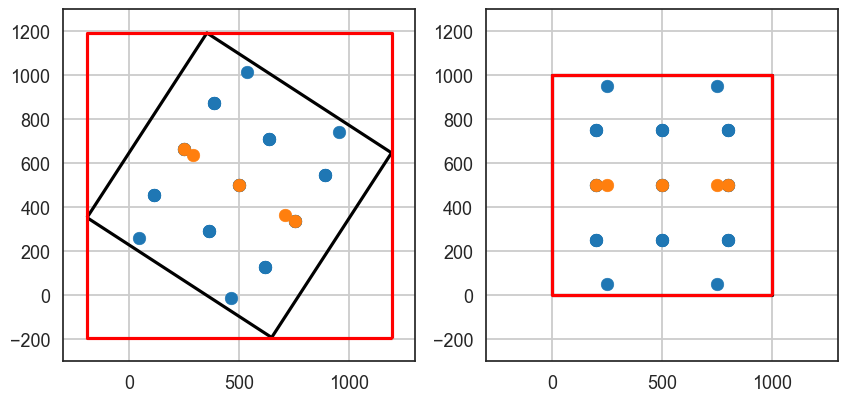

In [9]:
fig, (ax1, ax) = plt.subplots(1,2, figsize=(10,7))

extent_gdf_straight.boundary.plot(ax=ax, color='black')
interfaces_straight.plot(ax=ax)
orientations_straight.plot(ax=ax)
gpd.GeoDataFrame(geometry=[box(*extent_gdf_straight.total_bounds)]).boundary.plot(ax=ax, color='red')
ax.grid()
ax.set_ylim(-300,1300)
ax.set_xlim(-300,1300)


extent_gdf.boundary.plot(ax=ax1, color='black')
interfaces_rotated.plot(ax=ax1)
orientations_rotated.plot(ax=ax1)
gpd.GeoDataFrame(geometry=[box(*extent_gdf.total_bounds)]).boundary.plot(ax=ax1, color='red')
ax1.grid()
ax1.set_ylim(-300,1300)
ax1.set_xlim(-300,1300)

## Creating the GemPy Model

In [10]:
geo_model = gp.create_model('Graben_Model')
geo_model

Graben_Model  2023-08-01 14:29

In [11]:
gp.init_data(geo_model, [0, 1000, 0, 1000, -600, 0], [50,50,50],
             surface_points_df=interfaces_straight,
             orientations_df=orientations_straight,
             default_values=True)

Active grids: ['regular']


Graben_Model  2023-08-01 14:29

In [12]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Layer1,Default series,1,#015482,1
1,Layer2,Default series,2,#9f0052,2
2,Layer3,Default series,3,#ffbe00,3
3,Fault1,Default series,4,#728f02,4
4,Fault2,Default series,5,#443988,5


In [13]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Fault1': ('Fault1'),
                          'Fault2': ('Fault2'),
                          'Strata1': ('Layer1', 'Layer2', 'Layer3'),                          
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')
geo_model.set_is_fault(['Fault1', 'Fault2'])
geo_model.surfaces

Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.


,surface,series,order_surfaces,color,id
3,Fault1,Fault1,1,#527682,1
4,Fault2,Fault2,1,#527682,2
0,Layer1,Strata1,1,#ffbe00,3
1,Layer2,Strata1,2,#728f02,4
2,Layer3,Strata1,3,#443988,5
5,Basement,Strata1,4,#ff3f20,6


In [14]:
geo_model.set_topography(source='random')

[-120.    0.]
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  10.        ,   10.        , -594.        ],
       [  10.        ,   10.        , -582.        ],
       [  10.        ,   10.        , -570.        ],
       ...,
       [1000.        ,  959.18367347,  -48.98763452],
       [1000.        ,  979.59183673,  -56.49305639],
       [1000.        , 1000.        ,  -61.62003486]])

In [15]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
3,Fault1,Fault1,1,#527682,1
4,Fault2,Fault2,1,#527682,2
0,Layer1,Strata1,1,#ffbe00,3
1,Layer2,Strata1,2,#728f02,4
2,Layer3,Strata1,3,#443988,5
5,Basement,Strata1,4,#ff3f20,6


In [16]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

Widget(value="<iframe src='http://localhost:57216/index.html?ui=P_0x1b00e903100_0&reconnect=auto' style='width…

In [17]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging=False
                    )

Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                     values
range              1536.23
$C_o$             56190.48
drift equations  [3, 3, 3]


In [18]:
sol = gp.compute_model(geo_model, compute_mesh=True)

In [19]:
gp.plot_3d(geo_model, notebook=True)

Widget(value="<iframe src='http://localhost:57216/index.html?ui=P_0x1b024d4c880_1&reconnect=auto' style='width…

## Extracting Depth Maps from GemPy Model

We now extract the depth maps from the GemPy Model which will then be rotated using Py

In [20]:
meshes = gg.visualization.create_depth_maps_from_gempy(geo_model, surfaces=['Layer2', 'Fault1', 'Fault2'])
meshes

{'Layer2': [PolyData (0x1b024dab9a0)
    N Cells:    7938
    N Points:   4100
    N Strips:   0
    X Bounds:   1.000e+01, 9.900e+02
    Y Bounds:   1.000e+01, 9.900e+02
    Z Bounds:   -4.000e+02, -2.000e+02
    N Arrays:   1,
  '#728f02'],
 'Fault1': [PolyData (0x1b024da8160)
    N Cells:    5820
    N Points:   3038
    N Strips:   0
    X Bounds:   2.096e+02, 5.352e+02
    Y Bounds:   1.000e+01, 9.900e+02
    Z Bounds:   -5.940e+02, -3.000e+01
    N Arrays:   1,
  '#527682'],
 'Fault2': [PolyData (0x1b024da9240)
    N Cells:    5720
    N Points:   2990
    N Strips:   0
    X Bounds:   4.648e+02, 7.904e+02
    Y Bounds:   1.000e+01, 9.900e+02
    Z Bounds:   -5.940e+02, -3.000e+01
    N Arrays:   1,
  '#527682']}

## Rotating Meshes

The meshes will be rotated around the center of the extent to reach their original position. 

In [22]:
x,y = list(extent_gdf.iloc[0]['geometry'].centroid.coords)[0][0], list(extent_gdf.iloc[0]['geometry'].centroid.coords)[0][1]
x,y

(500.00000000000006, 500.00000000000006)

In [23]:
mesh_layer2 = meshes['Layer2'][0].rotate_z(angle=33, point=(x,y,0))
mesh_fault1 = meshes['Fault1'][0].rotate_z(angle=33, point=(x,y,0))
mesh_fault2 = meshes['Fault2'][0].rotate_z(angle=33, point=(x,y,0))

## Plotting the rotates Meshes

Rotating the meshes will result in the original position of the layers. The meshes/surfaces can now be used for further calculations and computations or exported to a GIS System.

In [24]:
p = pv.Plotter(notebook=True)

p.add_mesh(mesh_layer2, color= meshes['Layer2'][1])

p.add_mesh(mesh_fault1, color= meshes['Fault1'][1])

p.add_mesh(mesh_fault2, color= meshes['Fault2'][1])

p.set_background('white')
p.show_grid(color='black')
p.show()

Widget(value="<iframe src='http://localhost:57216/index.html?ui=P_0x1b02de3ac20_2&reconnect=auto' style='width…